In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from random import randint
import uuid,json
import matplotlib.pyplot as plt
    
from quinine import QuinineArgumentParser
from tqdm import tqdm
import torch
import yaml
import numpy as np
from eval import get_run_metrics
from tasks import get_task_sampler
from samplers import get_data_sampler
from curriculum import Curriculum
from schema_eval import schema
from schema import TASK_TO_DATA
from models import build_model
import random
from functools import wraps
from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results
from evaluate_ode_cur import get_paras, calculate_error_stats, plot_comparison, plot_error_analysis, generate_equation_params, plot_solution, get_steps

run_dir = "../../models12"

In [3]:
df = df = read_run_dir(run_dir)
df

run_path: ../../models12/ode_ivp_case2/9a20d467-9e5a-4883-9b98-2e4a141e55e3
run_path: ../../models12/ode_ivp_case2/83537d68-2a0b-4203-bae8-2436022f22a5
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/63c577f5-86a4-40a0-a9de-0dae6ab109c5
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/57654663-c4b8-4f5b-9336-44631ff33875
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/dfaed326-a2a7-4bc6-aff7-6e68d5ebeca2
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/15b8b341-cc45-475e-af48-4092a345f638
run_path: ../../models12/ode_ivp_case2vec_valid/a60e3ec6-223c-4b95-8fe3-8fdc0b5196da
run_path: ../../models12/ode_ivp_case2vec_valid/c80b634b-9003-4d46-998c-9985ddcd28e9
run_path: ../../models12/ode_ivp_case2vec_valid/f409869b-cfcf-4aca-bb72-454fb1b84e3c
run_path: ../../models12/ode_ivp_case2vec_valid/23aafa8d-fd90-4d39-b266-527a8e27657b
run_path: ../../models12/ode_ivp_case1plus/282a9fa2-268d-4397-a03d-fca6ce75675f
run_path: ../../models12/ode_ivp_case1/24c1872a-7ff7-427

,run_id,task,model,steps,num_tasks,num_examples,n_dims,n_layer,n_head,run_name,kwargs
17,cf0e52d6-7902-425c-8ccb-f2d52004b686,longrun_ode_ivp_case2_layer24,Transformer-12 layers,20000001,-1,-1,50,24,8,longrun_ode_ivp_case2_layer24,
26,d2f56364-4349-45ac-a123-13efa50db576,ode_ivp_case1plus_enhancedloss,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_enhancedloss_run1,
20,b895f496-ad85-4545-a100-212c99ea9341,ode_ivp_case1plus_valid,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_valid_run_01,
18,c3e94367-a517-47de-9eae-f74b3e1abd80,ode_ivp_case1plus_valid,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_valid_run_11,
11,24c1872a-7ff7-427f-9d41-ff57d6b7ee1f,ode_ivp_case1,Transformer,500001,-1,-1,20,12,8,ode_ivp_case1_run3,
27,d99eaaaa-791d-465c-8eb3-9a44b9faa660,ode_ivp_case1plus_enhancedloss,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_enhancedloss_run_0303,
24,ac0443e1-12d4-4fe5-9f23-998216b35556,ode_ivp_case1plus_h_enhancedloss,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_enhancedloss_run_015,
15,591e2f19-6813-4881-a30f-21f4a579e8ed,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_01,
13,de07feef-381a-4ead-843e-3283eb5588d2,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_02,
14,2fde25f5-5b9d-4ff6-a914-6b28b0ea5a98,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_11,


In [4]:
# 选择模型
run_names = [
    "ode_ivp_case2fin_valid_layer12",
    # "ode_ivp_case2vec_valid_layer24",
    # "longrun_ode_ivp_case2_layer24",
]
run_id = [
    "8f4129a9-d210-41fd-a0f2-4c17c633da9d",
    # "15b8b341-cc45-475e-af48-4092a345f638",
    # "cf0e52d6-7902-425c-8ccb-f2d52004b686",
    ]
output_labels = [
    "ode_ivp_case2fin_valid_layer12",
    # "ode_ivp_case2vec_valid_layer24",
    # "longrun_ode_ivp_case2_layer24",
    ]
run_paths = [os.path.join(run_dir, output_label, run_id) for run_id, output_label in zip(run_id, output_labels)]


## 加载模型 加载输入输出

In [5]:
model, conf = get_model_from_run(run_paths[0])
n_dims = conf.model.n_dims
shift_para = {
    'a_1': (-1, -1),
    'a_2': (0.5, 0.5),      # 增大系数
    'b_1': (-1, -1),    # 中等强度激励项
    'b_2': (1.28, 1.28),
    'y_0': (0.5, 0.5),
    't_e': (2.0, 2.0),    # 固定时间范围
    'steps': (10, 80)      # 步数范围对应h=0.2~0.025
}
# shift_para = {
#     'a_1': (-0.73, -0.73),
#     'a_2': (-0.04, -0.04),      # 增大系数
#     'b_1': (-0.63, -0.63),    # 中等强度激励项
#     'b_2': (1.28, 1.28),
#     'y_0': (0.5, 0.5),
#     't_e': (2.0, 2.0),    # 固定时间范围
#     'steps': (10, 80)      # 步数范围对应h=0.2~0.025
# }
batch_size = conf.training.batch_size
n_points = conf.training.curriculum.points.end
data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler()
xs = data_sampler.continuous_sample_xs(b_size=batch_size, n_points=n_points,use_h=False ,shifted_paras=shift_para)
ys = task.evaluate(xs)

outputs = []

run_path: ../../models12/ode_ivp_case2fin_valid_layer12/8f4129a9-d210-41fd-a0f2-4c17c633da9d


In [6]:
for run_path in tqdm(run_paths):
    model, _ = get_model_from_run(run_path)
    model.eval()
    model.cuda()
    with torch.no_grad():
        xs, ys = xs.cuda(), ys.cuda()
        output = model(xs, ys)
    outputs.append(output)

  0%|          | 0/1 [00:00<?, ?it/s]

run_path: ../../models12/ode_ivp_case2fin_valid_layer12/8f4129a9-d210-41fd-a0f2-4c17c633da9d


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


In [7]:
alll_steps = xs[:,:,6]
print(xs[:,:,6])

tensor([[10., 10., 10.,  ..., 10., 10., 10.],
        [10., 10., 10.,  ..., 10., 10., 10.],
        [10., 11., 11.,  ..., 11., 11., 11.],
        ...,
        [10., 11., 12.,  ..., 48., 49., 50.],
        [10., 11., 12.,  ..., 48., 49., 50.],
        [10., 11., 12.,  ..., 48., 49., 50.]], device='cuda:0')


## 画图

In [23]:
# 保存评估结果路径
eval_path = "../figs"

save_paras_file = os.path.join(eval_path, "paras.json")
if not os.path.exists(save_paras_file):
    with open(save_paras_file, "w") as f:
        json.dump([], f, indent=2)

print(eval_path)

../figs


In [9]:
# classic_typs = ["euler_explicit","euler_implicit","RK23","euler_improved","euler_adaptive", "BDF"]
classic_typs = ["euler_explicit","euler_implicit"] #,"RK23"] 
y_classic = []
for typ in classic_typs:
    task_sampler_classic = get_task_sampler(
        "ode_ivp_case2BSL",
        n_dims,
        batch_size
    )
    task_classic = task_sampler_classic()
    y_classic.append(task_classic.evaluate(xs, method=typ))

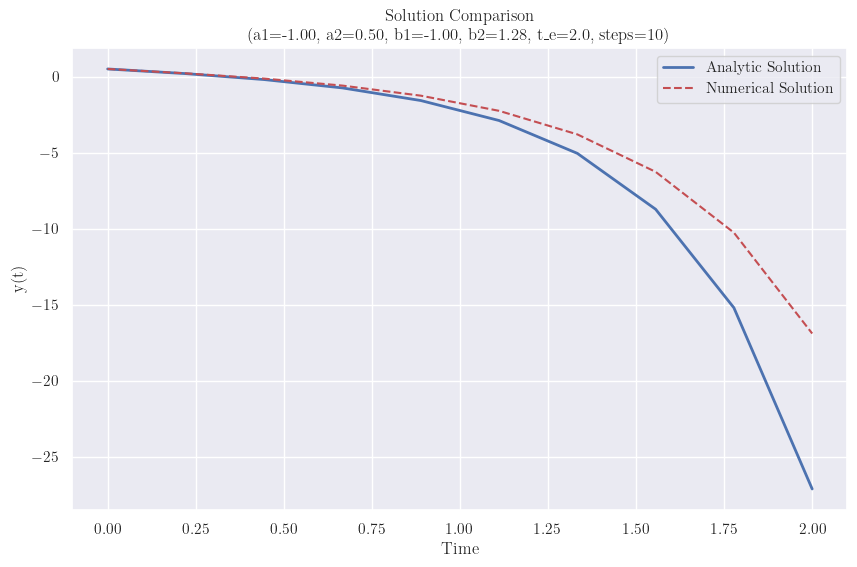

In [10]:
equation_title, filename_params, h_full, steps_full = generate_equation_params(conf, xs, n_points)
# plot_solution(xs, ys, y_classic[-1], conf.training.data, 0, 0,save_path=os.path.join(eval_path, f"classic_plot_{equation_title}.png") )
plot_solution(xs, ys, y_classic[-1], 0, 0,save_path=os.path.join(eval_path, f"classic_plot_{equation_title}.png") )

In [11]:
plot_ys = []
plot_ys.extend(outputs)
plot_ys.extend(y_classic)
plot_labels = []
plot_labels.extend(output_labels)
plot_labels.extend(classic_typs)

In [12]:
print(plot_ys[0].cpu().numpy().shape)

(64, 41, 50)


In [13]:
# task_sampler_acc =  get_task_sampler(
#         "ode_ivp_case2BSL",
#         n_dims,
#         batch_size
# )
# task_acc = task_sampler_acc()
# ys_acc = task_acc.evaluate(xs,method = "DOP853")
# ys = ys_acc

In [14]:
# # 转换模型输出结果
# all_errs = []
# for k in range(len(plot_labels)):
#     shorts_error = []
#     current_pred = plot_ys[k]
#     for i in range(xs.shape[0]):
#         # 一个task
#         # 取最后一个shots的值
#         j = (n_points - i - 1)
#         eval_y = current_pred[i, j]
#         steps,t_eval,paras = get_paras(conf.training.data, xs, ys, eval_y, i, j)
#         diff = abs(eval_y.cpu().numpy()-ys[i, j].cpu().numpy())
#         errs = (np.mean(diff[:steps]))
#         shorts_error.append(errs)
#     all_errs.append(shorts_error)
    

In [15]:
# print(diff[:steps+2])

In [16]:
# # mean_errs, max_errs, min_errs = calculate_error_stats(all_error)
# all_errs_array = np.array(all_errs)
# equation_title, filename_params, h_full, steps_full = generate_equation_params(conf, xs, n_points)
# plot_error_analysis(
#     x_values=steps_full,
#     y_values_list=all_errs_array[:, :n_points-4].tolist(),
#     x_label='Steps',
#     y_label='Error',
#     labels=plot_labels,
#     title=f'${equation_title}$\nError Change loglog',  # 将方程作为标题
#     save_path=os.path.join(eval_path, f"err_change_{filename_params}.png"),
#     # title=f'$1$Error Change loglog',  # 将方程作为标题
#     # save_path=os.path.join(eval_path, f"err_change_1.png"),
#     fit_line=True,
#     annotate_slope=True,
#     # annotate_start_end=True
# )

In [17]:
all_errs = []
for k in range(len(plot_labels)):
    # 每种类型的模型的数据
    shorts_error = []
    current_pred = plot_ys[k]
    for j in range(xs.shape[1]):
        # 一个task
        i = xs.shape[0] - 1
        # 取最后一行的数据，按照时间顺序取
        eval_y = current_pred[i, j]
        steps,t_eval,paras = get_paras(conf.training.data, xs, ys, eval_y, i, j)
        diff = abs(eval_y.cpu().numpy()-ys[i, j].cpu().numpy())
        errs = np.mean(diff[:steps])
        shorts_error.append(errs)
    all_errs.append(shorts_error)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


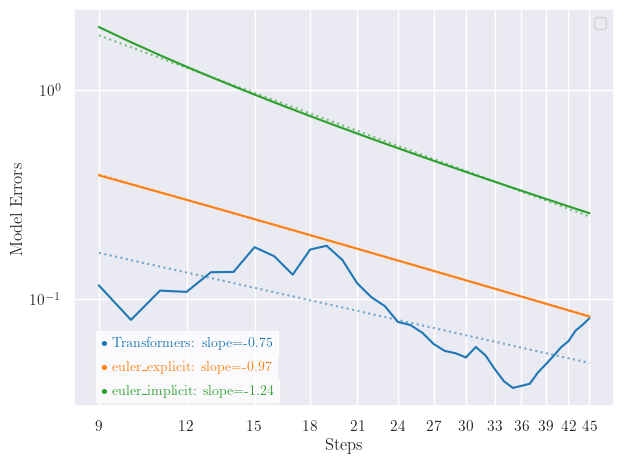

In [45]:
# mean_errs, max_errs, min_errs = calculate_error_stats(all_error)
all_errs_array = np.array(all_errs)
equation_title, filename_params, h_full, steps_full = generate_equation_params(conf, xs, n_points)
plotlabel = plot_labels
plotlabel[0] = 'Transformers'
plot_error_analysis(
    x_values=steps_full,
    y_values_list=all_errs_array[:, :n_points-4].tolist(),
    x_label='Steps',
    y_label='Model Errors',
    labels=plot_labels,
    # title=f'Error Change',  # 将方程作为标题
    save_path=os.path.join(eval_path, f"a_err_change_{filename_params}.pdf"),
    # title=f'$1$Error Change loglog',  # 将方程作为标题
    # save_path=os.path.join(eval_path, f"err_change_1.png"),
    fit_line=True,
    annotate_slope=True,
    # annotate_start_end=True
)

## yep
一些未完成，已完成但无用的部分，相当于留个心眼

In [19]:
# # 参数可视化 
# from IPython.display import display, Markdown
# import pandas as pd
# # 显示配置标题
# display(Markdown("### 🛠️ Model Configuration"))

# def dict_to_html(param_dict):
#     """将字典转换为带样式的HTML表格"""
#     if isinstance(param_dict, dict):
#         return pd.DataFrame([param_dict]).to_html(index=False, border=0, classes="param-table")
#     elif isinstance(param_dict, (list, tuple)):
#         return "<br>".join(str(x) for x in param_dict)
#     else:
#         return str(param_dict)

# # 修改后的参数处理
# conf_dict = {k: v.__dict__ if hasattr(v, '__dict__') else v for k, v in dict(conf).items()}
# df = pd.DataFrame.from_dict({
#     'Category': list(conf_dict.keys()),
#     'Parameters': [f"<div style='max-height: 200px; overflow: auto'>{dict_to_html(v)}</div>" 
#                    for v in conf_dict.values()]
# })

# # 优化显示格式
# pd.set_option('display.max_colwidth', None)
# display(df.style.set_properties(**{
#     'background-color': '#f8f9fa',
#     'color': '#212529',  # 新增深灰色字体
#     'border': '1px solid #dee2e6',
#     'padding': '0.5rem',
#     'font-size': '0.95em'  # 调大字号
# }).set_table_styles([{
#     'selector': 'td',
#     'props': [('font-family', 'monospace')]  # 等宽字体更清晰
# }]))

# # 核心参数摘要表格
# display(Markdown("### 📊 Key Parameters"))
# key_params = {
#     'Model Architecture': [
#         ('n_dims', conf.model.n_dims),
#         ('n_layers', conf.model.n_layer),
#         ('n_heads', conf.model.n_head)
#     ],
#     'Training Setup': [
#         ('Batch Size', conf.training.batch_size),
#         ('Learning Rate', conf.training.learning_rate),
#         ('Training Steps', conf.training.train_steps)
#     ]
# }

# dfs = []
# for category, params in key_params.items():
#     temp_df = pd.DataFrame(params, columns=['Parameter', 'Value'])
#     temp_df['Category'] = category
#     dfs.append(temp_df)

# display(pd.concat(dfs).pivot(index='Category', columns='Parameter', values='Value')
#         .style.format(precision=2)
#         .set_table_styles([{
#             'selector': 'th',
#             'props': [
#                 ('font-size', '0.9em'),
#                 ('background-color', '#4a6572'),  # 更深的背景
#                 ('color', '#212529')  # 白色字体
#             ]
#         }, {
#             'selector': 'td',
#             'props': [('color', '#2c3e50')]  # 深蓝色字体
#         }]))

In [20]:
# n_dims = 50
# n_points = 41
# bsize = 64
# taskname = 'ode_ivp_case2vec'
# dataname= 'ode_ivp_case2'  

In [21]:
# # 准备数据
# task_sampler_args = {}

# data = get_data_sampler(dataname, n_dims)
# task_sampler = get_task_sampler(taskname, n_dims, bsize)
# task = task_sampler(**task_sampler_args)

# xs = data.continuous_sample_xs(b_size=bsize, n_points=n_points,use_h=False)
# # ys = task.evaluate(xs)

In [22]:
# print(xs[:,:,6])
# steps = xs[:,:,6]